# Utilizarea Rețelei Generativ Adversariale StarGAN în aplicații practice


## Pași inițiali pentru utilizare

Pentru acestă parte a proiectului, am fi putut folosi variantele de StarGAN implementate în Pytorch, Tensorflow sau nnabla. Am decis să utilizăm preponderent modulul nnabla, pentru că oferă un model mult mai customizabil și pe care l-am mai tweak-uit pentru a efectua exact operațiile necesare pentru procesările de imagini.

Inițial, trebuie să clonăm proiectul de pe repositoriul de Github și să instalam modulul *nnabla-ext-cuda100* pentru a putea utiliza placa video pentru modelele din modulul **nnabla**.

In [1]:
!pip install nnabla-ext-cuda100
!git clone https://github.com/DreamUnibucTeam/Practical-Applications-of-StarGAN.git
# %run nnabla-examples/interactive-demos/colab_utils.py
%cd Practical-Applications-of-StarGAN/nnabla-stargan/

     |████████████████████████████████| 51.1 MB 215 kB/s 
     |████████████████████████████████| 18.1 MB 954 kB/s 
     |████████████████████████████████| 132 kB 73.0 MB/s 
     |████████████████████████████████| 79 kB 10.6 MB/s 
     |████████████████████████████████| 8.7 MB 58.5 MB/s 
     |████████████████████████████████| 138 kB 76.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Cloning into 'Practical-Applications-of-StarGAN'...
remote: Enumerating objects: 544, done.
remote: Counting o

In [2]:
!git pull
!git log

Already up to date.
commit c636a2ce83565e9c09e30e2dd2760cc875f744eb (HEAD -> main, origin/main, origin/HEAD)
Author: nicu-ducal <nicu.ducal01@gmail.com>
Date:   Mon Apr 18 16:19:03 2022 +0300

    feat(dataset): Add dataset processing to notebook and results

commit 260be5378bead96bb065d7ab0a322ad38c10a72e
Author: nicu-ducal <nicu.ducal01@gmail.com>
Date:   Mon Apr 18 12:42:39 2022 +0300

    fix(): Fix video recorder function

commit 486dd2ba8f6f40b898bb7bc1ebb61dc86dafde8a
Author: nicu-ducal <nicu.ducal01@gmail.com>
Date:   Mon Apr 18 12:28:37 2022 +0300

    feat(video-rec): Add video recorder for colab

commit 1aed1ced5a59892de9f3ee296c2bc3954601d160
Author: nicu-ducal <nicu.ducal01@gmail.com>
Date:   Mon Apr 18 12:19:45 2022 +0300

    feat(): Add new functions to notebook

commit d80efd01c18c23e1990e65b81fd7a67fa91d7166
Author: nicu-ducal <nicu.ducal01@gmail.com>
Date:   Mon Apr 18 11:30:53 2022 +0300

    chore(): Remove useless comments

commit b12f981133cb4f082735d8486c7e442c0

Obținem modelul preantrenat de StarGAN din **nnabla**, antrenat pe fețele din setul de date *CelebA*, împreună cu fișierul JSON care conține configurația modelului, necesară pentru a-l rula.

In [2]:
!wget https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_params_on_celebA.h5
!wget https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_conf_on_celebA.json

--2022-04-18 18:49:06--  https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_params_on_celebA.h5
Resolving nnabla.org (nnabla.org)... 13.33.96.2, 13.33.96.15, 13.33.96.112, ...
Connecting to nnabla.org (nnabla.org)|13.33.96.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212881888 (203M) [binary/octet-stream]
Saving to: ‘pretrained_params_on_celebA.h5’

pretrained_params_o 100%[===================>] 203.02M   289MB/s    in 0.7s    

2022-04-18 18:49:07 (289 MB/s) - ‘pretrained_params_on_celebA.h5’ saved [212881888/212881888]

--2022-04-18 18:49:07--  https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_conf_on_celebA.json
Resolving nnabla.org (nnabla.org)... 13.33.96.2, 13.33.96.15, 13.33.96.112, ...
Connecting to nnabla.org (nnabla.org)|13.33.96.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775 [application/json]
Saving to: ‘pretrained_conf_on_celebA.json’

pretrained_conf_on_ 10

Modelul de StarGAN ar trebui să primească ca input o imagine care conține regiunea feței persoanei, iar din acest motiv, dacă primim ca input o imagine ce conține mai multe detalii, nu doar regiunea facială, ar trebui să facem crop feței sau fețelor din acea imagine.

Pentru acesta, putem folosi modelul de detecție facială din modulul **dlib** sau **MTCNN** implementat în librăria Pytorch.

In [3]:
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!bzip2 -d mmod_human_face_detector.dat.bz2

--2022-04-18 18:49:08--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K   623KB/s    in 1.1s    

2022-04-18 18:49:09 (623 KB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



Importam, de asemenea, modulele globale necesare pentru proiectul nostru.

In [4]:
import cv2 as cv
import dlib
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
from nnabla.utils.image_utils import imread, imresize, imsave


import os
import shutil

# import torch
# import torch.nn as nn

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
2022-04-18 18:49:11,386 [nnabla][INFO]: Initializing CPU extension...


Inițializăm detectorul facial din modulul **dlib** pentru a putea fi utilizat în funcțiile următoare.

In [5]:
face_detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

De asemenea, vom avea nevoie și de câteva funcții utilitare (*transform* și *crop*) pentru a putea procesa imaginile. Aceste funcții au fost obținute din modelul [FAN: Facial Alignment Network](https://github.com/sony/nnabla-examples/tree/master/facial-keypoint-detection/face-alignment) și simplificate doar pentru task-ul nostru.

In [6]:
def transform(point, center, scale, resolution, invert=False):
    """Generate and affine transformation matrix.
    Given a set of points, a center, a scale and a target resolution, the
    function generates and affine transformation matrix. If invert is ``True``
    it will produce the inverse transformation.
    Arguments:
        point {numpy.array} -- the input 2D point
        center {numpy.array} -- the center around which to perform the transformations
        scale {float} -- the scale of the face/object
        resolution {float} -- the output resolution
    Keyword Arguments:
        invert {bool} -- define wherever the function should produce the direct or the
        inverse transformation matrix (default: {False})
    """
    point.append(1)

    h = 200.0 * scale
    t = np.eye(3)
    t[0, 0] = resolution / h
    t[1, 1] = resolution / h
    t[0, 2] = resolution * (-center[0] / h + 0.5)
    t[1, 2] = resolution * (-center[1] / h + 0.5)

    if invert:
        t = np.reshape(np.linalg.inv(np.reshape(t, [1, 3, 3])), [3, 3])

    new_point = np.reshape(np.matmul(
        np.reshape(t, [1, 3, 3]), np.reshape(point, [1, 3, 1])), [3, ])[0:2]

    return new_point.astype(int)


def crop(image, center, scale, resolution=256, show_transformed=True):
    """Center crops an image or set of heatmaps
    Arguments:
        image {numpy.array} -- an rgb image
        center {numpy.array} -- the center of the object, usually the same as of the bounding box
        scale {float} -- scale of the face
    Keyword Arguments:
        resolution {float} -- the size of the output cropped image (default: {256.0})
    Returns:
        [type] -- [description]
    """  # Crop around the center point
    """ Crops the image around the center. Input is expected to be an np.ndarray """
    ul = transform([1, 1], center, scale, resolution, True)
    br = transform([resolution, resolution], center, scale, resolution, True)
    
    # Afisarea dupa transformarea afina
    if show_transformed:
        print(f"Detectia dupa transformarea afina (upper-left = {ul}, bottom-right = {br}):")
        test_img = cv.cvtColor(image.copy(), cv.COLOR_RGB2BGR)
        cv.rectangle(test_img, tuple(ul), tuple(br), (0,255,0), 1)
        cv2_imshow(test_img)

    if image.ndim > 2:
        newDim = np.array([br[1] - ul[1], br[0] - ul[0],
                           image.shape[2]], dtype=np.int32)
        newImg = np.zeros(newDim, dtype=np.uint8)
    else:
        newDim = np.array([br[1] - ul[1], br[0] - ul[0]], dtype=np.int)
        newImg = np.zeros(newDim, dtype=np.uint8)
    ht = image.shape[0]
    wd = image.shape[1]
    newX = np.array(
        [max(1, -ul[0] + 1), min(br[0], wd) - ul[0]], dtype=np.int32)
    newY = np.array(
        [max(1, -ul[1] + 1), min(br[1], ht) - ul[1]], dtype=np.int32)
    oldX = np.array(
        [int(max(1, ul[0] + 1)), int(min(br[0], wd))], dtype=np.int32)
    oldY = np.array(
        [int(max(1, ul[1] + 1)), int(min(br[1], ht))], dtype=np.int32)

    newImg[newY[0] - 1:newY[1], newX[0] - 1:newX[1]
           ] = image[oldY[0] - 1:oldY[1], oldX[0] - 1:oldX[1], :]

    newImg = cv.resize(newImg, dsize=(int(resolution), int(resolution)),
                        interpolation=cv.INTER_LINEAR)
    return newImg, ul, br

### 1. Testarea modelului StarGAN cu selfie-uri

Pentru prima aplicație, vom testa modelul preantrenat de StarGAN pe selfie-uri. Pentru aceasta, dacă mașina utilizatorului are o cameră video, puteți rula următorul cod pentru a face un selfie, apoi să procesăm 

<IPython.core.display.Javascript object>

Captura a fost salvata in fisierul capture.png


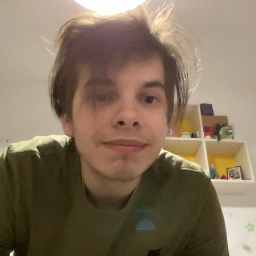

In [7]:
# Atentie la acest import! 
# Trebuie sa va asigurati ca sunteti in folderul nnabla-stargan
from utils.colab_utils import take_photo
from google.colab.patches import cv2_imshow

try:
    img_path = "capture.png"
    image_name = take_photo(filename=img_path, cam_width=256, cam_height=256)
    print('Captura a fost salvata in fisierul {}'.format(image_name))
    
    # Afisarea imaginii obținute
    img = cv.imread(image_name)
    cv2_imshow(img)
except Exception as err:
    print(str(err))

Transferăm poza într-un alt folder.

In [8]:
os.makedirs("selfies/processed", exist_ok=True)
shutil.move(img_path, f"selfies/{img_path}")

'selfies/capture.png'

Vom folosi apoi o funcție de procesare a capturii pentru a extrage regiunea feței pentru a putea să o trecem prin modelul nostru de StarGAN.

In [9]:
def process_captured_image(img_name, output_img_name, face_detector, face_detector_lib='dlib', show_transformed=True):
    img = io.imread(img_name)
    if img.ndim == 2:
        img = color.gray2rgb(img)
    elif img.shape[-1] == 4:
        img = img[..., :3]

    # Daca folosim detectorul din dlib, acestea vor fi fețele detectate
    if face_detector_lib == 'dlib':
        detected_faces = face_detector(cv.cvtColor(img[..., ::-1].copy(), cv.COLOR_BGR2GRAY))
        detected_faces = [[d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()] for d in detected_faces]

    assert len(detected_faces) == 1, "Atentie: Poza trebuie sa contina o singura fata."
    face = detected_faces[0]

    # Afisarea detectiei faciale
    if show_transformed:
        print("Detectia faciala:")
        test_img = cv.cvtColor(img.copy(), cv.COLOR_RGB2BGR)
        cv.rectangle(test_img, (face[0], face[1]), (face[2], face[3]), (255,0 ,0), 1)
        cv2_imshow(test_img)

    center = [face[2] - (face[2] - face[0]) / 2.0,
            face[3] - (face[3] - face[1]) / 2.0]
    scale = (face[2] - face[0] + face[3] - face[1]) / 195
    cropped_img, ul, br = crop(img, center, scale, resolution=128, show_transformed=show_transformed)

    if show_transformed:
        plt.imshow(cropped_img)

    io.imsave(output_img_name, cropped_img)
    return cropped_img, ul, br

Detectia faciala:


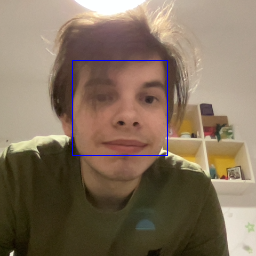

Detectia dupa transformarea afina (upper-left = [23 11], bottom-right = [216 204]):


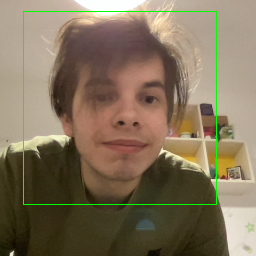

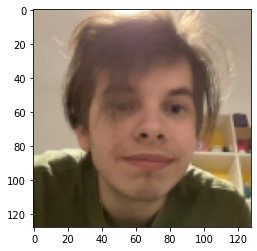

In [10]:
face_img, ul, br = process_captured_image(
    img_name=f"selfies/{img_path}", 
    output_img_name=f"selfies/processed/face_{img_path}", 
    face_detector=face_detector)

În continuare, după ce am obținut poza cropată cu fața, putem să o trecem prin StarGAN și să selectăm ce atribute dorim să modificăm.

**Atenție!** Pentru a rula pe imaginea obținută, trebuie să indicație path-ul corect către imagine.

In [12]:
!python generate.py --pretrained-params pretrained_params_on_celebA.h5 --config pretrained_conf_on_celebA.json --test-image-path ./selfies/processed/ --result-save-path ./selfies/generated/

2022-04-18 16:34:09,586 [nnabla][INFO]: Initializing CPU extension...
2022-04-18 16:34:10,269 [nnabla][INFO]: Initializing CUDA extension...
2022-04-18 16:34:10,275 [nnabla][INFO]: Initializing cuDNN extension...
Learned attributes choice: ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
Source image: face_capture.png
Use 'Black_Hair'?
type yes or no: yews
type 'yes' or 'no'.
type yes or no: yes
Use 'Blond_Hair'?
type yes or no: no
Use 'Brown_Hair'?
type yes or no: no
Use 'Male'?
type yes or no: yes
Use 'Young'?
type yes or no: yes
Saved ./selfies/generated/generated_0_Black_Hair_Male_Young.png.


Putem să afișăm acum imaginea procesată cu ajutorul StarGAN-ului. Putem să o comparăm și cu poza inițială.

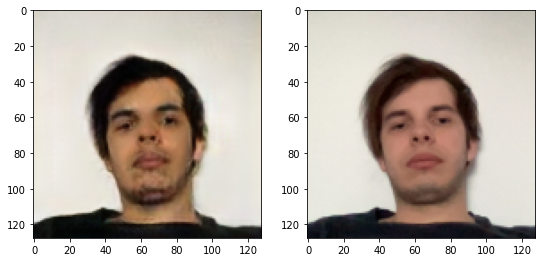

In [13]:
generated_img = imread("./selfies/generated/generated_0_Black_Hair_Male_Young.png")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9))
ax1.imshow(generated_img)
ax2.imshow(face_img)
plt.show()

Putem să înlocuim imaginea obținută în poza inițială și să observăm cum arată.

In [57]:
def apply_stargan_patch(img, patch, ul, br):
    img = img.copy()
    if img.shape[-1] == 4:
        img = img[..., :3]

    (x0, y0), (x1, y1) = ul, br
    resized_patch = imresize(patch, (x1 - x0, y1 - y0))

    # Elimina spatiile negre din crop
    h, w = img.shape[:2]
    ph, pw = resized_patch.shape[:2]
    act_x0, act_y0, act_x1, act_y1 = max(0, x0), max(0, y0), min(w, x1), min(h, y1)
    dx0, dy0, dx1, dy1 = abs(act_x0 - x0), abs(act_y0 - y0), abs(act_x1 - x1), abs(act_y1 - y1)
    
    img[act_y0:act_y1, act_x0:act_x1, :] = resized_patch[dy0:ph - dy1, dx0:pw - dx1]
    return img

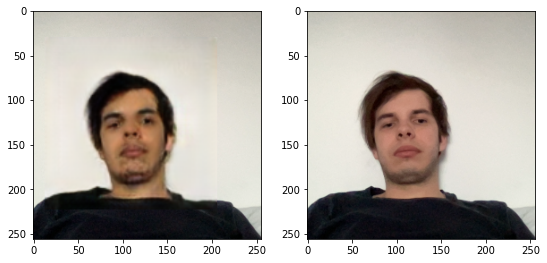

In [15]:
img = imread(f"./selfies/{img_path}")
orig_img = img.copy()

img = apply_stargan_patch(img, generated_img, ul, br)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9))
ax1.imshow(img)
ax2.imshow(orig_img)
plt.show()

### 2. Modificarea codului pentru ambele variante de StarGAN (din Pytorch si nnabla)

În continuare, una din particularitățile incomode ale implementărilor modelelor de StarGAN din ambele framework-uri este faptul că ambele necesită rulare din linia de comandă a fișierelor `.py` respective. Din acest motiv, am decis să adugăm pentru ambele pachete funcțiile noastre care pot fi importate într-un proiect care conține dependințele necesare modului de StarGAN și pot fi rulate din cod, fără să fie nevoie de a salva imaginile ca `.png` sau `.jpg`, rula din linia de comanda scripturile de generare a imaginilor și din nou să citim din fișierul creat imaginea generată. Acest lucru este anevoios și neeficient, iar din acest motiv am implementat funcțiile `run_stargan_on_image` și `run_stargan_on_images`.

Vom testa în continuare pe modelul din **nnabla**. Inițial, trebuie să încărcăm fișierul JSON care conține configurația modelului preantrenat de StarGAN, cât și path-ul către fișierul `.h5` cu modelul preantrenat.

In [11]:
import json
with open("pretrained_conf_on_celebA.json") as f:
    used_config = json.load(f)

paramfile = used_config["pretrained_params"]
print(used_config)

{'c_dim': 5, 'celeba_crop_size': 178, 'image_size': 128, 'g_conv_dim': 64, 'd_conv_dim': 64, 'g_repeat_num': 6, 'd_repeat_num': 6, 'context': 'cudnn', 'device_id': '0', 'type_config': 'float', 'batch_size': 8, 'max_epoch': 20, 'g_lr': 0.0001, 'd_lr': 0.0001, 'n_critic': 5, 'beta1': 0.5, 'beta2': 0.999, 'selected_attrs': ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'], 'lambda_cls': 1, 'lambda_rec': 10, 'lambda_gp': 10, 'test_during_training': False, 'num_data': None, 'num_test': 30, 'celeba_image_dir': 'data/celeba/images', 'attr_path': 'data/celeba/list_attr_celeba.txt', 'log_step': 100, 'sample_step': 1000, 'lr_update_step': 1000, 'monitor_path': 'final_result', 'model_save_path': 'final_result', 'pretrained_params': 'pretrained_params_on_celebA.h5'}


Apoi, importăm din scriptul `generate.py` funcțiile sus-menționate și testăm pe imaginea care a fost cropată la etapa precedentă.

Learned attributes choice: ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']


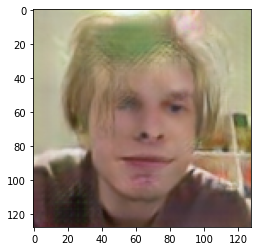

In [12]:
from generate import run_stargan_on_image, run_stargan_on_images

# Trebuie sa indicam corect labelul de atribute: [Black_Hair, Blond_Hair, Brown_Hair, Male, Young], yes = 1, no = 0
res_img = run_stargan_on_image(face_img, used_config, paramfile, [0, 1, 0, 1, 1])
plt.imshow(res_img)
plt.show()

Astfel, putem să rulăm modelul pe anumite dataseturi destul de eficient și ușor. 

### 3. Rularea modelului de StarGAN pe dataseturi de imagini care conțin regiuni faciale

Acum că avem funcții utilitare care pot efectua operația de generare a imaginilor într-un mod mult mai ușor

Vom copia pozele deja procesate cu fețele persoanelor din datasetul creat de noi și le vom trece prin StarGAN cu anumiți parametri și vom analiza rezultatele.

In [ ]:
BASE_PATH = "./data/faces"
shutil.copytree("../data/faces", BASE_PATH)
img_files = sorted(os.listdir(BASE_PATH))

Vom rula acum StarGAN cu opțiunile Black Hair, Male și Young.

In [ ]:
from generate import run_stargan_on_image, run_stargan_on_images

face_imgs = [imresize(imread(f"{BASE_PATH}/{img_name}"), (128, 128)) for img_name in img_files]
generated_imgs = run_stargan_on_images(face_imgs, used_config, paramfile, attributes=[1, 0, 0, 1, 1])
os.makedirs("./data/faces_black_hair_male_young", exist_ok=True)
for img_name, img_gen in zip(img_files, generated_imgs):
    imsave(f"./data/faces_black_hair_male_young/{img_name}", img_gen)

Learned attributes choice: ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']


Putem să încercăm și cu opțiunile Blong Hair, Female, Old.

In [ ]:
generated_imgs_2 = run_stargan_on_images(face_imgs, used_config, paramfile, attributes=[0, 1, 0, 0, 0])
os.makedirs("./data/faces_blond_hair_female_old", exist_ok=True)
for img_name, img_gen in zip(img_files, generated_imgs_2):
    imsave(f"./data/faces_blond_hair_female_old/{img_name}", img_gen)

Learned attributes choice: ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']


Putem să combinăm în continuare cele două rezultate și să le comparăm cu originalul.

In [ ]:
os.makedirs("./data/faces_combined/", exist_ok=True)
for img_name, img, gen_img_1, gen_img_2 in zip(img_files, face_imgs, generated_imgs, generated_imgs_2):
    img = img / 255.0 # transform to [0, 1]
    comb_img = np.concatenate((img, gen_img_1, gen_img_2), axis=1)
    imsave(f"./data/faces_combined/{img_name}", comb_img)

Salvăm rezultatele într-o arhivă zip pentru a putea să le descărcăm mai ușor, dacă avem nevoie de ele.

In [ ]:
shutil.make_archive('./data', 'zip', './', 'data')

'/content/Practical-Applications-of-StarGAN/nnabla-stargan/data.zip'

### 4. Aplicații ale modelului de StarGAN pe videouri

O altă potențială aplicație a StarGAN-ului pot fi videourile. În continuare, vă propunem utilizarea unor scripturi pentru crearea unui video, înregistrat cu camera mașinii, ca și în cazul aplicației ce utiliza selfie-ul persoanei.

**Atenție!** Sugerăm să înregistrați un video scurt pentru a nu avea probleme cu procesarea îndelungată a frame-urilor.

In [17]:
from utils.colab_utils import record_video
from google.colab.patches import cv2_imshow

try:
    vid_path = "capture.mp4"
    vid_name = record_video(filename=vid_path, cam_width=256, cam_height=256)
    print('Captura a fost salvata in fisierul {}'.format(vid_name))
    
    # Afisarea imaginii obținute
    # img = cv.imread(image_name)
    # cv2_imshow(img)
except Exception as err:
    print(str(err))

argument should be a bytes-like object or ASCII string, not 'NoneType'
Captura a fost salvata in fisierul capture.mp4


Putem să vizualizăm videoul obținut.

In [18]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open(vid_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=256 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Vom avea nevoie și de unele funcții ajutătoare pentru a transforma videoul în frame-uri, înainte de procesare și pentru a uni frame-urile procesate într-un nou video.

In [13]:
# Functie care imparte un video in mai multe frame-uri
def get_frames_from_video(filename):
    frames = []
    capture = cv.VideoCapture(filename)
    while True:
        success, frame = capture.read()
        if not success:
            # raise Exception(f"Error during splitting into frames of {filename}")
            break
        frames.append(frame)

    capture.release()
    return frames

# Functie care combina mai multe frame-uri intr-un singur video
def combine_frames_to_video(frames, filename):
    fourcc = cv.VideoWriter_fourcc(*'MP4V')
    size = tuple(frames[0].shape[:-1])
    fps = 30
    out = cv.VideoWriter(filename, fourcc, fps, size)
    
    for frame in frames:
        out.write(frame)
    out.release()

In [14]:
def process_frame(img, face_detector, face_detector_lib='dlib', show_transformed=True):
    if img.ndim == 2:
        img = color.gray2rgb(img)
    elif img.shape[-1] == 4:
        img = img[..., :3]

    # Daca folosim detectorul din dlib, acestea vor fi fețele detectate
    if face_detector_lib == 'dlib':
        detected_faces = face_detector(cv.cvtColor(img[..., ::-1].copy(), cv.COLOR_BGR2GRAY))
        detected_faces = [[d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()] for d in detected_faces]

    assert len(detected_faces) == 1, "Atentie: Poza trebuie sa contina o singura fata."
    face = detected_faces[0]

    # Afisarea detectiei faciale
    if show_transformed:
        print("Detectia faciala:")
        test_img = cv.cvtColor(img.copy(), cv.COLOR_RGB2BGR)
        cv.rectangle(test_img, (face[0], face[1]), (face[2], face[3]), (255,0 ,0), 1)
        cv2_imshow(test_img)

    center = [face[2] - (face[2] - face[0]) / 2.0,
            face[3] - (face[3] - face[1]) / 2.0]
    scale = (face[2] - face[0] + face[3] - face[1]) / 195
    cropped_img, ul, br = crop(img, center, scale, resolution=128, show_transformed=show_transformed)

    if show_transformed:
        plt.imshow(cropped_img)

    return cropped_img, ul, br

Putem extrage acum frame-urile din videoul nostru.

In [63]:
frames = get_frames_from_video(vid_path)

# Trebuie sa convertim imaginile din BGR in RGB
rgb_frames = [cv.cvtColor(frame, cv.COLOR_BGR2RGB) for frame in frames]

Trebuie să extragem din fiecare frame regiunea facială, dar și să postrăm punctele de upper-left și bottom-right pentru fiecare frame. Putem folosi un dicționar pentru asta.

In [64]:
frame_data = []
face_imgs = []
for i, frame in enumerate(rgb_frames):
    face_img, ul, br = process_frame(
        frame,
        face_detector=face_detector,
        show_transformed=False
    )
    frame_data.append((ul, br))
    face_imgs.append(face_img)

Putem să trecem acum prin StarGAN toate fețele capturate.

In [35]:
# Vom genera imagini cu par blond, femeie, tanara
generated_imgs = run_stargan_on_images(face_imgs, used_config, paramfile, attributes=[0, 1, 0, 0, 1])
# Interesting fact, a rulat 183 secunde pe 95 de frame-uri => 1.9 sec/img (destul de mult)

Learned attributes choice: ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']


Aducem imaginile in formatul BGR, care este clasic pentru **OpenCV** și normalizăm de la [0, 1] la [0, 255].

In [52]:
normalized_imgs = cv.normalize(generated_imgs, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype = cv.CV_32F).astype(np.uint8)
cv_norm_imgs = [cv.cvtColor(img, cv.COLOR_BGR2RGB) for img in normalized_imgs]

Putem face un video din frame-urile obtinute, sa vedem cum ar arata.

In [55]:
combine_frames_to_video(cv_norm_imgs, "processed_face_capture.mp4")

Putem să înlocuim acum fațele procesate în videoul inițial și să comparăm cu cel original.

In [65]:
processed_frames = []
for patch, (ul, br), frame in zip(cv_norm_imgs, frame_data, frames):
    processed_frames.append(apply_stargan_patch(frame, patch, ul, br))

In [66]:
combine_frames_to_video(processed_frames, "processed_capture.mp4")

In [60]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('processed_capture.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=256 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)